In [1]:
import os
import tarfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import urllib.request
import scipy.io
from PIL import Image

In [2]:
data_dir = '/content'
image_dir = os.path.join(data_dir,'jpg')  #/content/jpg
label_file = os.path.join(data_dir,'imagelabels.mat')

In [3]:
url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
file_path = os.path.join(data_dir,'102flowers.tgz')
urllib.request.urlretrieve(url,file_path)

('/content/102flowers.tgz', <http.client.HTTPMessage at 0x7b3167b213f0>)

In [4]:
with tarfile.open(file_path,'r:gz') as tar:
  tar.list()
  tar.extractall(path=data_dir)

Streaming output truncated to the last 5000 lines.
?rwxr-xr-x men/men      38318 2009-02-19 15:21:00 jpg/image_02266.jpg 
?rwxr-xr-x men/men      59135 2009-02-19 15:20:47 jpg/image_00062.jpg 
?rwxr-xr-x men/men      61470 2009-02-19 15:21:18 jpg/image_05821.jpg 
?rwxr-xr-x men/men      55335 2009-02-19 15:21:07 jpg/image_03712.jpg 
?rwxr-xr-x men/men      24281 2009-02-19 15:20:54 jpg/image_01142.jpg 
?rwxr-xr-x men/men      40836 2009-02-19 15:21:04 jpg/image_03033.jpg 
?rwxr-xr-x men/men      73085 2009-02-19 15:21:17 jpg/image_05760.jpg 
?rwxr-xr-x men/men      37638 2009-02-19 15:21:02 jpg/image_02732.jpg 
?rwxr-xr-x men/men      42141 2009-02-19 15:20:47 jpg/image_00183.jpg 
?rwxr-xr-x men/men      55137 2009-02-19 15:21:15 jpg/image_05264.jpg 
?rwxr-xr-x men/men      37223 2009-02-19 15:21:08 jpg/image_03778.jpg 
?rwxr-xr-x men/men      65333 2009-02-19 15:21:24 jpg/image_07061.jpg 
?rwxr-xr-x men/men      50527 2009-02-19 15:21:11 jpg/image_04468.jpg 
?rwxr-xr-x men/men      50

In [5]:
class FlowerDataset(Dataset):
  def __init__(self,image_dir,label_file,transform=None):
    self.image_dir = image_dir
    self.transform = transform

    #Load image labels
    mat = scipy.io.loadmat(label_file)
    self.labels = mat['labels'].flatten() - 1   #Python 0,1,2,3  Matlab 1,2,3,4

    #Load image file names
    self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    self.image_files.sort()

  def __len__(self):
    return len(self.image_files)


  def __getitem__(self,idx):
    img_name = self.image_files[idx]
    img_path = os.path.join(self.image_dir,img_name)
    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image)

    label = self.labels[idx]
    return image, torch.tensor(label, dtype=torch.long)

In [6]:
image_size = 64
batch_size = 64
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)), #Resize all the images to 64*64
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])   #Normalized_Pixel = (pixel-mean)/STD  #(Red,Green,Blue)
])

dataset = FlowerDataset(image_dir=image_dir,label_file=label_file,transform=transform)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [7]:
class ConditionalGenerator(nn.Module):
  def __init__(self,latent_dim,label_dim):
    super(ConditionalGenerator,self).__init__()
    self.label_embedding = nn.Embedding(num_classes,label_dim)
    self.model = nn.Sequential(
        nn.Linear(latent_dim+label_dim,256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,1024),
        nn.ReLU(),
        nn.Linear(1024,3*image_size*image_size),
        nn.Tanh()
    )

  def forward(self,noise,labels):
    label_emb = self.label_embedding(labels)
    gen_input = torch.cat((noise,label_emb),-1)
    img = self.model(gen_input)
    img = img.view(img.size(0),3,image_size,image_size)  #(batch_size,3,height,width)
    return img



In [8]:
class ConditionalDiscriminator(nn.Module):
  def __init__(self,label_dim):
    super(ConditionalDiscriminator,self).__init__()
    self.label_embedding = nn.Embedding(num_classes,label_dim)
    self.model = nn.Sequential(
      nn.Linear(3*image_size*image_size+label_dim,512),
      nn.LeakyReLU(0.2),
      nn.Linear(512,256),
      nn.LeakyReLU(0.2),
      nn.Linear(256,1),
      nn.Sigmoid()  # Output in the range of 0 and 1, close to 1 (real) and close 0 means (fake)
    )

  def forward(self,img,labels):
    img_flat = img.view(img.size(0),-1)
    label_emb = self.label_embedding(labels)
    d_in = torch.cat((img_flat,label_emb),-1)
    validity = self.model(d_in)
    return validity

In [9]:
num_classes = 102
latent_dim = 100
label_dim = 50

#Initialize models
generator = ConditionalGenerator(latent_dim,label_dim)
discriminator = ConditionalDiscriminator(label_dim)

#Loss function & Optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(),lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(),lr=0.0002)

In [10]:
n_epochs = 100

#Training Loop
for epoch in range(n_epochs):
  for i,(imgs,labels) in enumerate(dataloader):
    label_emb = labels
    real_imgs = imgs

    valid = torch.ones(imgs.size(0),1)
    fake = torch.zeros(imgs.size(0),1)

    #Train Discriminator
    optimizer_D.zero_grad()
    real_loss = adversarial_loss(discriminator(real_imgs,label_emb),valid)
    fake_imgs = generator(torch.randn(imgs.size(0),latent_dim),label_emb).detach()
    fake_loss = adversarial_loss(discriminator(fake_imgs,label_emb),fake)
    d_loss = (real_loss+fake_loss)/2
    d_loss.backward()
    optimizer_D.step()

    #Train Generator
    optimizer_G.zero_grad()
    gen_imgs = generator(torch.randn(imgs.size(0),latent_dim),label_emb)
    g_loss = adversarial_loss(discriminator(gen_imgs,label_emb),valid)
    g_loss.backward()
    optimizer_G.step()

  print(f"Epoch [{epoch+1}/{n_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}") # Epoch [1/100] | D Loss:   G Loss:


Epoch [1/100] | D Loss: 0.09622623771429062 | G Loss: 5.1360087394714355
Epoch [2/100] | D Loss: 1.4653222560882568 | G Loss: 2.6862332820892334
Epoch [3/100] | D Loss: 0.1485154628753662 | G Loss: 3.040759563446045
Epoch [4/100] | D Loss: 0.3334296941757202 | G Loss: 2.0584375858306885
Epoch [5/100] | D Loss: 0.31386423110961914 | G Loss: 2.437053680419922
Epoch [6/100] | D Loss: 0.05323367565870285 | G Loss: 4.299360275268555
Epoch [7/100] | D Loss: 0.2605307400226593 | G Loss: 2.2599101066589355
Epoch [8/100] | D Loss: 0.6648396253585815 | G Loss: 1.427268385887146
Epoch [9/100] | D Loss: 1.239296317100525 | G Loss: 13.929095268249512
Epoch [10/100] | D Loss: 0.12769028544425964 | G Loss: 12.427420616149902
Epoch [11/100] | D Loss: 0.11015655100345612 | G Loss: 3.1698639392852783
Epoch [12/100] | D Loss: 0.11503924429416656 | G Loss: 3.835601806640625
Epoch [13/100] | D Loss: 0.26702743768692017 | G Loss: 2.1590797901153564
Epoch [14/100] | D Loss: 0.0993024930357933 | G Loss: 4.321

In [12]:
torch.save(generator.state_dict(),'generator.pth')
torch.save(discriminator.state_dict(),'discriminator.pth')

In [ ]:
#generator.load_state_dict(torch.load('generator.pth'))
#discriminator.load_state_dict(torch.load('discriminator.pth'))
#generator.eval()
#discriminator.eval()

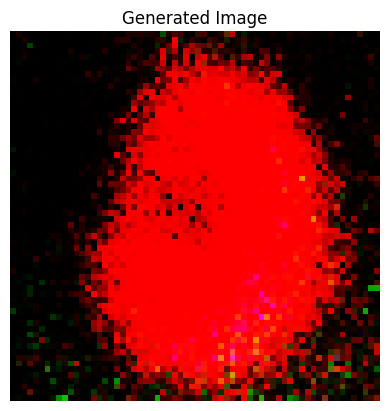

In [16]:
def generate_and_display_image(label,generator,latent_dim,num_classes):
  generator.eval()

  if label < 0 or label > num_classes:
    raise ValueError(f'Label Should be between 0 and 102')

  #Generate a batch of random noise
  noise = torch.randn(1,latent_dim)

  #Conver label to tensor
  label_tensor = torch.tensor([label],dtype=torch.long)

  #Generate image
  with torch.no_grad():
    generated_img = generator(noise,label_tensor)

  #Convert the image to numpy and set the dimension
  generated_img = generated_img.squeeze().permute(1,2,0).numpy()  #(Channel,Height,Width) (0,1,2)
  generated_img = (generated_img+1)/2  #Rescale to [0,1]

  #Display image
  plt.imshow(generated_img)
  plt.title(f"Generated Image")
  plt.axis('off')
  plt.show()

# Example
label_to_generate = 26
generate_and_display_image(label_to_generate,generator,latent_dim,num_classes)
